In [1]:
#import Libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  
from utils.utils_functions import Utils_functions
from sklearn.metrics import silhouette_score

In [2]:
X, y = Utils_functions.load_data()

#faccio 4 procedimenti complementari, uno con i dati raw, uno con i dati normalizzati, uno con i dati standardizzati e uno con le componenti principali estratte tramite la pca, durante l'esplorazione del 
#dataset abbiamo notato come il 90% della varianza viene spiegato dalle prime 8 componenti.

#preprocesso i dati
datasets, datasets_names, pca_components = Utils_functions.process_data(X)

Numero di componenti necessarie per spiegare almeno il 90.0% della varianza: 8


In [3]:
#rispettivamente per ciascun dataset indicano:
#start eps, end eps, step eps
dbscan_eps_params = [
    [50, 500, 50],          # Dataset 1 
    [0.1, 2.0, 0.1],        # Dataset 2
    [0.05, 1.0, 0.05],      # Dataset 3
    [0.1, 2.0, 0.1]         # Dataset 4
]

#rispettivamente per ciascun dataset indicano:
#start min sample, end min sample, step min sample
dbscan_min_sample_params = [
    [5, 50, 5],     # Dataset 1 
    [3, 30, 3],     # Dataset 2
    [3, 30, 3],     # Dataset 3
    [3, 30, 3]      # Dataset 4
]

Best Parameters with Dataset: Raw
Best eps: 50
Best min_samples: 30
Best Score: 0.2679


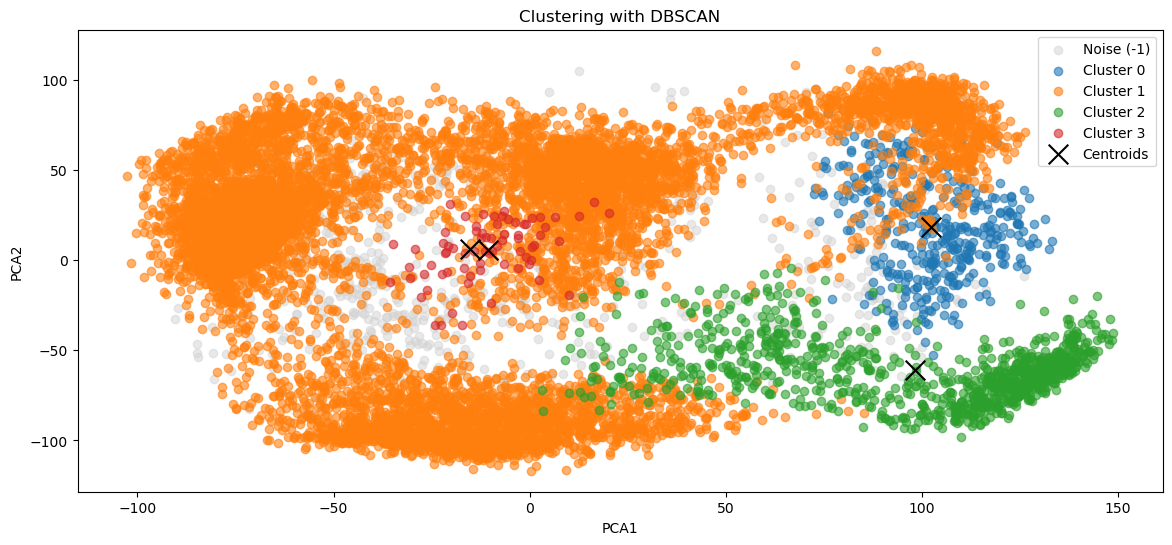

Metriche con Dataset: Raw
ARI: 0.05082469808836484
NMI: 0.26933913692191175
Homogeneity: 0.17592077413417795
Completeness: 0.574314722426307
V-Measure: 0.26933913692191175
SSE: 127988676.14
MSE: 11643.80

Numero di elementi di rumore: 619
Numero di cluster generati: 4



Best Parameters with Dataset: Standardized
Best eps: 1.2000000000000002
Best min_samples: 27
Best Score: 0.7101


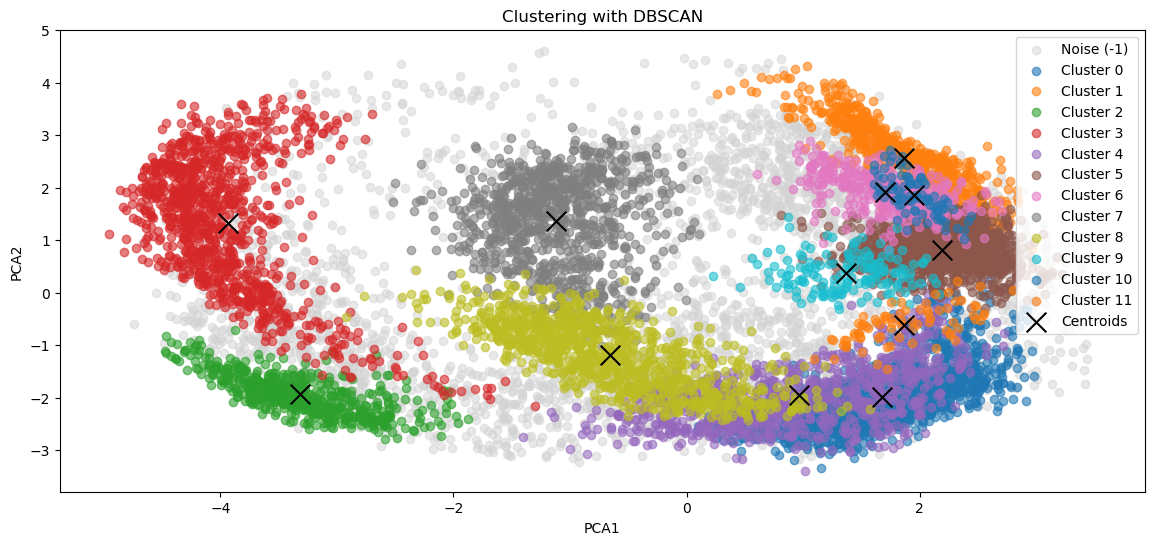

Metriche con Dataset: Standardized
ARI: 0.5519686909837576
NMI: 0.7496111997201489
Homogeneity: 0.7392250546876911
Completeness: 0.7602933553173729
V-Measure: 0.7496111997201489
SSE: 28533.17
MSE: 2.60

Numero di elementi di rumore: 2888
Numero di cluster generati: 12



Best Parameters with Dataset: Normalized
Best eps: 0.30000000000000004
Best min_samples: 6
Best Score: 0.6878


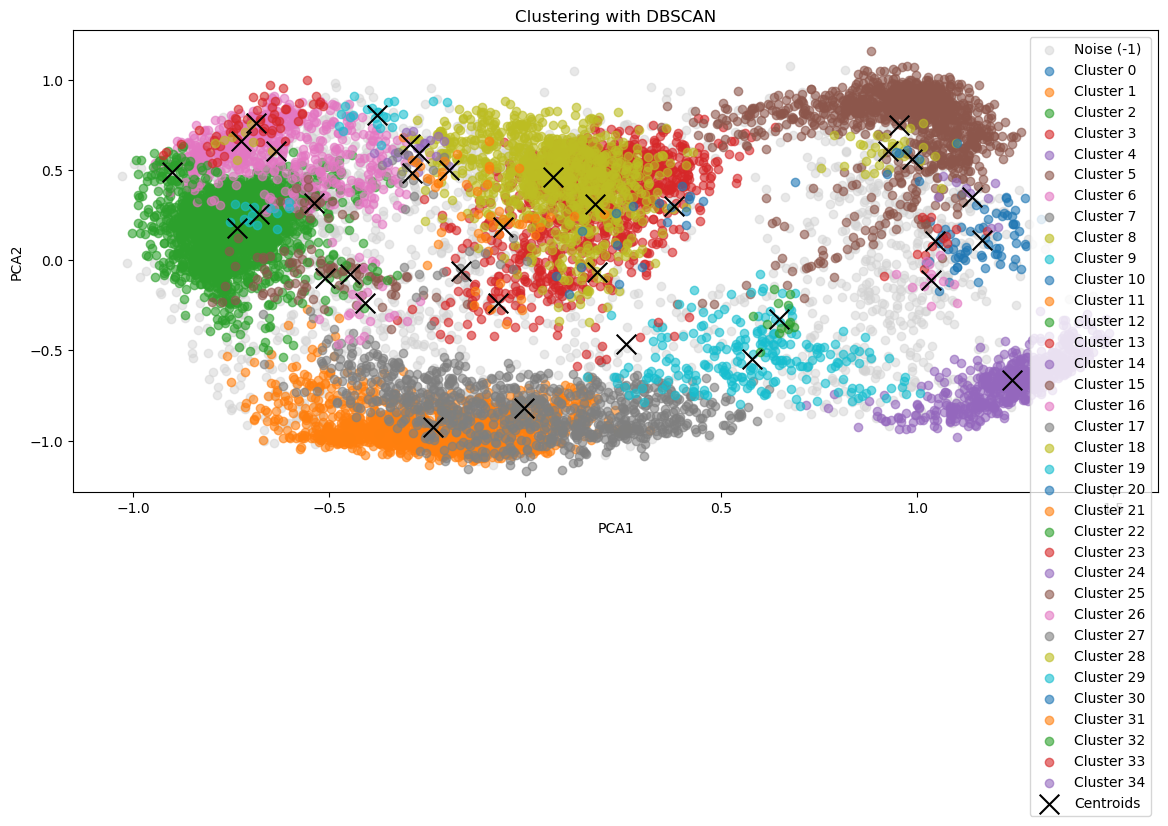

Metriche con Dataset: Normalized
ARI: 0.5647748812676239
NMI: 0.7182987318774516
Homogeneity: 0.7371550375179412
Completeness: 0.7003830477385449
V-Measure: 0.7182987318774519
SSE: 3400.43
MSE: 0.31

Numero di elementi di rumore: 1769
Numero di cluster generati: 35



Best Parameters with Dataset: Extracted
Best eps: 1.0
Best min_samples: 27
Best Score: 0.6476


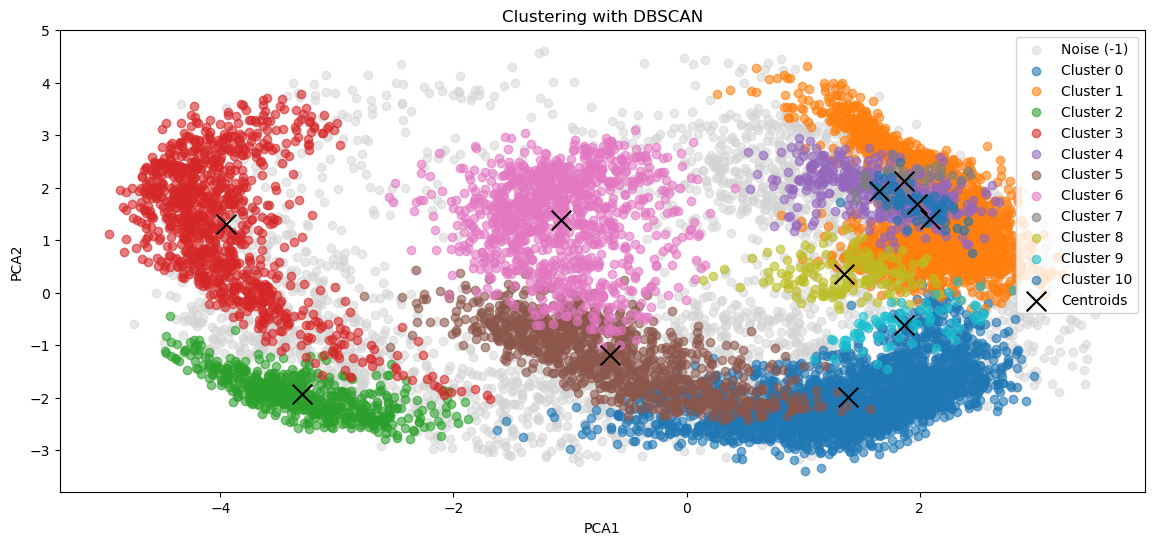

Metriche con Dataset: Extracted
PCA components: 8
ARI: 0.4911013229387872
NMI: 0.6854505078758405
Homogeneity: 0.646826252808074
Completeness: 0.7289804787586901
V-Measure: 0.6854505078758405
SSE: 32518.68
MSE: 2.96

Numero di elementi di rumore: 2579
Numero di cluster generati: 11





In [4]:
#colonne per PCA
columns = [f"PCA{i}" for i in range(1, pca_components + 1)]
columns_2d = columns[:2]
columns_3d = columns[:3]

for i, X in enumerate(datasets):
    
    #calcolo i parametri ottimali per DBSCAN
    best_eps, best_min_samples, best_score = Utils_functions.find_optimal_params_dbscan(
        X,
        y,
        eps_params=dbscan_eps_params[i],
        min_samples_params=dbscan_min_sample_params[i]
    )

    print(f"Best Parameters with Dataset: {datasets_names[i]}")
    print(f"Best eps: {best_eps}")
    print(f"Best min_samples: {best_min_samples}")
    print(f"Best Score: {best_score:.4f}")
    
    #inzializzo il modello DBSCAN
    # - eps: distanza massima tra due campioni per essere considerati nello stesso cluster
    # - min_samples: numero minimo di campioni in un vicinato per essere considerato core point
    dbscan = DBSCAN(eps = best_eps, min_samples = best_min_samples)
    
    #eseguo il clustering con DBSCAN
    labels = dbscan.fit_predict(X)

    #riduzione dimensionale per i plot
    if (i < 3):
        #inizializzo la PCA
        pca = PCA(n_components = pca_components)
        
        #addestro lo scaler con il dataset
        reduced_data = pca.fit_transform(X)
        
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(reduced_data, columns=columns)
          
    else:
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(X, columns=columns)
        
        #non riduco le dimensioni perchè ho già le componenti principali
        reduced_data = X
    
    
    #aggiungo la colonna con i cluster
    df_pca['Cluster'] = labels

    #calcolo i centroidi come media dei punti per ogni cluster
    #DBSCAN assegna -1 ai punti considerati rumore (outliers).
    #quindi, evito di calcolare il "centroide" per la classe -1.
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels != -1]  # escludo il cluster -1
    
    
    #inizializzo la lista dei centroidi
    centroids = []
    
    #calcolo dei centroidi solo per i cluster validi (non rumore)
    for cluster_id in valid_labels:
        
        #seleziono i punti del cluster corrente
        cluster_points = reduced_data[labels == cluster_id]
        
        #calcolo il centroide come media dei punti
        centroid = cluster_points.mean(axis=0)
        
        #aggiungo il centroide alla lista
        centroids.append(centroid)
        
    #trasformo la lista in un array numpy
    centroids = np.array(centroids)
    
    
    

    # Plotto i dati in 2D, distinguendo il cluster -1 (rumore) dagli altri
    plt.figure(figsize=(14, 6))
    
    # Colori per i cluster
    # Se ci sono cluster -1 e altri cluster, li gestisco separatamente
    noise_data = df_pca[df_pca['Cluster'] == -1]
    if not noise_data.empty:
        plt.scatter(noise_data['PCA1'], noise_data['PCA2'],
                    label='Noise (-1)',
                    alpha=0.5,
                    c='lightgray')

    # Per ogni cluster valido, plotto i punti
    for cluster_id in valid_labels:
        cluster_data = df_pca[df_pca['Cluster'] == cluster_id]
        plt.scatter(cluster_data[columns_2d[0]],
                    cluster_data[columns_2d[1]],
                    label=f'Cluster {cluster_id}',
                    alpha=0.6)
    
    # Plotto i centroidi calcolati
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x',
                    s=200,
                    c='black',
                    label='Centroids')
    
    plt.title('Clustering with DBSCAN')
    plt.xlabel(columns_2d[0])
    plt.ylabel(columns_2d[1])
    plt.legend()
    plt.show()

    #calcolo i valori di similarità
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)
    vms = v_measure_score(y, labels)

    #calcolo SSE e MSE
    sse = Utils_functions.compute_SSE(X, labels)
    mse = sse / X.shape[0]
    
    #estraiamo il rumore
    noise = df_pca[df_pca['Cluster'] == -1]
    
    #calcoliamo il numero di elementi di rumore
    n_noise = noise.shape[0]
    
    #calcolo anche il numero di cluster generati
    n_clusters = len(np.unique(labels)) - 1

    print(f"Metriche con Dataset: {datasets_names[i]}")
    
    if i == 3:
        print(f"PCA components: {pca_components}")
    
    print(f"ARI: {ari}")
    print(f"NMI: {nmi}")
    print(f"Homogeneity: {hom}")
    print(f"Completeness: {comp}")
    print(f"V-Measure: {vms}")
    print(f"SSE: {sse:.2f}")
    print(f"MSE: {mse:.2f}\n")
    print(f"Numero di elementi di rumore: {n_noise}")
    print(f"Numero di cluster generati: {n_clusters}\n")
    print("\n")